# Find published articles missing from bioRxiv

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import plotnine as p9
from scipy.spatial.distance import cdist
import tqdm

# Load Embeddings

## bioRxiv

In [2]:
biorxiv_journal_df = (
    pd.read_csv(
        "../journal_tracker/output/mapped_published_doi.tsv", 
        sep="\t"
    )
    .groupby("doi")
    .agg({
        "document":"last",
        "category":"first",
        "journal":"first",
        "doi":"last",
        "published_doi":"first",  
        "pmcid":"first", 
    })
    .reset_index(drop=True)
)
biorxiv_journal_df.head()

,document,category,journal,doi,published_doi,pmcid
0,000026_v1.xml,genetics,PLoS Genetics,10.1101/000026,10.1371/journal.pgen.1004412,PMC4125079
1,000042_v2.xml,genomics,Nature Reviews Genetics,10.1101/000042,10.1038/nrg3723,NaN
2,000067_v1.xml,genomics,Nature,10.1101/000067,10.1038/nature12904,PMC4285441
3,000091_v1.xml,synthetic biology,NaN,10.1101/000091,NaN,NaN
4,000109_v1.xml,evolutionary biology,PLoS Genetics,10.1101/000109,10.1371/journal.pgen.1004410,PMC4072524


In [3]:
biorxiv_embed_df = (
    pd.read_csv(
        Path("../word_vector_experiment/output/") /
        "word2vec_output/" /
        "biorxiv_all_articles_300.tsv.xz",
        sep="\t"
    )   
)
biorxiv_embed_df.head()

,document,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,...,feat_290,feat_291,feat_292,feat_293,feat_294,feat_295,feat_296,feat_297,feat_298,feat_299
0,440735_v1.xml,-0.185549,-0.028703,-0.148555,-0.133172,0.353365,-0.114964,-0.028663,-0.215159,0.551382,...,-0.286513,0.082141,-0.197929,-0.163326,-0.867377,-0.383934,0.684275,0.673811,0.332528,-0.252338
1,775270_v1.xml,-0.532040,-0.065809,-0.313654,-0.117575,0.372866,-0.318956,-0.368010,0.325850,0.808698,...,-0.199805,-0.083095,0.184185,-0.157145,-0.895367,-0.611417,0.224433,0.857584,-0.442240,-0.229249
2,242404_v1.xml,-0.511104,-0.203790,-0.171574,0.244052,0.235567,-0.269997,-0.222966,-0.247174,0.385497,...,-0.351890,-0.155088,-0.222041,-0.258185,-0.866121,-0.568663,0.553375,0.890001,0.025051,-0.347382
3,872994_v1.xml,-0.595936,-0.147790,-0.277296,0.522433,0.574653,-0.046103,-0.586993,-0.312505,0.382142,...,0.074240,0.042758,0.174565,0.155595,-0.557984,-0.445246,0.386596,0.512007,-0.510197,-0.295844
4,080853_v2.xml,-0.076522,0.039275,-0.928818,0.226103,0.035823,-0.075580,-0.189354,0.243075,0.240977,...,0.524121,0.560223,0.246179,0.242929,-0.810809,-0.118951,0.052647,0.184235,-0.154029,0.469902


In [4]:
biorxiv_journal_mapped_df = (
    biorxiv_journal_df[["document", "pmcid"]]
    .merge(biorxiv_embed_df, on="document")
)
biorxiv_journal_mapped_df.head()

,document,pmcid,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,...,feat_290,feat_291,feat_292,feat_293,feat_294,feat_295,feat_296,feat_297,feat_298,feat_299
0,000026_v1.xml,PMC4125079,-0.354588,-0.039688,-0.264044,0.061171,0.445177,-0.094280,-0.207811,-0.268134,...,0.077113,0.009006,-0.128140,0.107098,-0.896259,-0.591504,0.451696,1.010107,0.155138,-0.141590
1,000042_v2.xml,NaN,-0.697319,-0.342986,-0.248835,-0.111381,0.244663,-0.238119,-0.140737,0.221334,...,-0.126911,0.238912,-0.035375,-0.044733,-0.693987,-0.188221,0.615959,0.625472,-0.067295,-0.161871
2,000067_v1.xml,PMC4285441,-0.223833,0.104426,-0.187421,-0.097920,0.118555,-0.162342,-0.065943,0.034351,...,0.110930,0.144949,0.003651,-0.035206,-0.887362,-0.582829,0.407179,0.400775,0.030982,0.238798
3,000091_v1.xml,NaN,-0.460216,-0.077183,-0.346650,0.354429,0.540097,-0.367523,-0.597944,-0.026886,...,0.313261,-0.251339,0.563322,0.144810,-0.369955,-0.624727,0.338073,0.619281,-0.313213,-0.013729
4,000109_v1.xml,PMC4072524,-0.359770,-0.034423,-0.211397,0.142895,0.257640,0.214825,0.053788,-0.111075,...,0.131452,0.034245,0.119621,-0.075230,-0.786596,-0.557854,0.163636,0.867464,0.000889,0.181491


## Pubmed Central

In [5]:
pmc_articles_df = (
    pd.read_csv(
        Path("../../pmc/exploratory_data_analysis/") /
        "output/pubmed_central_journal_paper_map.tsv.xz", 
        sep="\t"
    )
    .query("article_type=='research-article'")
)
pmc_articles_df.head()

,journal,article_type,doi,pmcid
0,Environ_Health,research-article,10.1186/1476-069X-5-22,PMC1552054
1,Environ_Health,research-article,10.1186/1476-069X-4-12,PMC1226148
3,Environ_Health,research-article,10.1186/s12940-017-0316-3,PMC5635510
4,Environ_Health,research-article,10.1186/1476-069X-10-46,PMC3125232
5,Environ_Health,research-article,10.1186/1476-069X-11-91,PMC3533997


In [6]:
pmc_embed_df = (
    pd.read_csv(
        list(
            Path("../../pmc/word_vector_experiment/output/")
            .glob("*300.tsv.xz")
        )[0],
        sep="\t"
    )
)
pmc_embed_df.head()

,document,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,...,feat_290,feat_291,feat_292,feat_293,feat_294,feat_295,feat_296,feat_297,feat_298,feat_299
0,PMC1552054,-0.428596,0.004477,-0.153677,0.059131,-0.394598,-0.066383,0.358798,-0.245809,0.431974,...,-0.067994,0.033121,-0.077121,-0.433617,-1.111247,-0.405260,0.293903,0.613155,-0.500204,-0.214057
1,PMC1226148,-0.434013,-0.185516,-0.070654,0.488759,-0.280275,0.042681,0.116685,0.037062,0.530896,...,0.318905,-0.065244,0.159258,-0.380412,-0.665559,-0.485417,0.180982,0.523053,-0.485158,-0.251244
2,PMC5635510,-0.248388,0.118660,-0.103008,0.267721,0.278939,-0.220584,0.089593,-0.159638,0.866190,...,0.081127,-0.110091,-0.031617,-0.188741,-0.936947,-0.461118,0.618781,0.647195,-0.270240,-0.409643
3,PMC3125232,-0.507224,0.024099,-0.039696,-0.171992,0.371326,-0.137797,-0.202616,-0.156994,0.695519,...,-0.218274,-0.022597,-0.028885,-0.250560,-1.140730,-0.568136,0.482088,0.899122,-0.250971,-0.592976
4,PMC3533997,-0.424435,0.175519,-0.048797,0.178023,-0.042913,-0.282377,0.317917,-0.007002,0.586774,...,-0.111805,-0.262620,-0.187817,-0.463804,-1.308874,-0.352892,0.251982,0.550853,-0.659678,-0.614042


In [7]:
pmc_journal_mapped_df = (
    pmc_articles_df[["journal", "pmcid"]]
    .merge(pmc_embed_df, left_on="pmcid", right_on="document")
    .drop("pmcid", axis=1)
)
pmc_journal_mapped_df.head()

,journal,document,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,...,feat_290,feat_291,feat_292,feat_293,feat_294,feat_295,feat_296,feat_297,feat_298,feat_299
0,Environ_Health,PMC1552054,-0.428596,0.004477,-0.153677,0.059131,-0.394598,-0.066383,0.358798,-0.245809,...,-0.067994,0.033121,-0.077121,-0.433617,-1.111247,-0.405260,0.293903,0.613155,-0.500204,-0.214057
1,Environ_Health,PMC1226148,-0.434013,-0.185516,-0.070654,0.488759,-0.280275,0.042681,0.116685,0.037062,...,0.318905,-0.065244,0.159258,-0.380412,-0.665559,-0.485417,0.180982,0.523053,-0.485158,-0.251244
2,Environ_Health,PMC5635510,-0.248388,0.118660,-0.103008,0.267721,0.278939,-0.220584,0.089593,-0.159638,...,0.081127,-0.110091,-0.031617,-0.188741,-0.936947,-0.461118,0.618781,0.647195,-0.270240,-0.409643
3,Environ_Health,PMC3125232,-0.507224,0.024099,-0.039696,-0.171992,0.371326,-0.137797,-0.202616,-0.156994,...,-0.218274,-0.022597,-0.028885,-0.250560,-1.140730,-0.568136,0.482088,0.899122,-0.250971,-0.592976
4,Environ_Health,PMC3533997,-0.424435,0.175519,-0.048797,0.178023,-0.042913,-0.282377,0.317917,-0.007002,...,-0.111805,-0.262620,-0.187817,-0.463804,-1.308874,-0.352892,0.251982,0.550853,-0.659678,-0.614042


# Calculate Distances

## biorxiv -> published versions

In [8]:
biorxiv_published = (
    biorxiv_journal_mapped_df
    .query("pmcid.notnull()")
    .sort_values("pmcid", ascending=True)
    .drop_duplicates("pmcid")
    .set_index("pmcid")
)
biorxiv_published.head()

,document,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,...,feat_290,feat_291,feat_292,feat_293,feat_294,feat_295,feat_296,feat_297,feat_298,feat_299
pmcid,,,,,,,,,,,,,,,,,,,,,
PMC3585962,000380_v1.xml,-0.089820,0.213478,-0.688674,-0.210780,0.250569,-0.188696,-0.600395,0.001966,0.835001,...,0.499104,0.145342,0.351161,-0.199782,-0.716037,-0.701872,0.209843,0.261151,-0.358704,-0.215744
PMC3866385,000968_v1.xml,-0.255329,0.274540,-0.293852,0.616544,0.524100,-0.057505,-0.383754,-0.602195,0.290291,...,-0.079164,0.038555,0.149628,0.216948,-0.875129,0.045080,0.847978,0.526043,-0.154849,-0.105887
PMC3893193,001297_v2.xml,-0.216976,-0.324127,-0.311663,0.593512,0.347711,-0.180897,-0.391476,-0.123292,0.365682,...,0.035644,0.246972,0.466131,0.193137,-0.501147,-0.566383,0.349670,0.751755,-0.369225,-0.157755
PMC3894166,000141_v1.xml,-0.489331,0.029247,-0.766819,0.126920,0.228847,-0.231903,-0.362439,0.288067,0.539021,...,0.390265,0.303159,0.268525,0.173529,-0.685519,-0.613437,0.188164,0.561036,0.024270,-0.074251
PMC3906208,000315_v1.xml,-0.104042,0.260326,-0.217748,-0.095333,-0.097044,-0.101123,0.092174,0.221908,0.440478,...,0.251430,0.733713,-0.425069,0.159021,-0.980853,0.014888,0.823273,0.441548,0.268824,-0.114512


In [9]:
PMC_pubished = (
    pmc_journal_mapped_df
    .query(f"document in {biorxiv_published.reset_index().pmcid.tolist()}")
    .sort_values("document", ascending=True)
    .set_index("document")
)
PMC_pubished.head()

,journal,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,...,feat_290,feat_291,feat_292,feat_293,feat_294,feat_295,feat_296,feat_297,feat_298,feat_299
document,,,,,,,,,,,,,,,,,,,,,
PMC3585962,Biochimie,-0.098884,0.214301,-0.645178,-0.272175,0.373711,-0.188448,-0.596447,-0.039941,0.982804,...,0.502021,0.073569,0.412591,-0.172567,-0.779263,-0.697926,0.369576,0.315655,-0.331896,-0.372914
PMC3866385,Front_Hum_Neurosci,-0.240794,0.307311,-0.202005,0.581624,0.644356,-0.006195,-0.435495,-0.641621,0.247778,...,-0.010112,0.024885,0.164740,0.282565,-0.826444,0.048025,0.924790,0.553071,-0.085559,-0.068807
PMC3893193,PLoS_One,-0.185743,-0.312882,-0.242535,0.560396,0.488412,-0.207604,-0.392894,-0.127650,0.458649,...,0.021451,0.185137,0.462166,0.328489,-0.486121,-0.511641,0.471794,0.813252,-0.352215,-0.204227
PMC3894166,PLoS_Comput_Biol,-0.503416,0.009370,-0.754106,0.152181,0.285587,-0.186768,-0.380495,0.292699,0.522160,...,0.414183,0.246784,0.284164,0.261274,-0.678757,-0.567737,0.203805,0.600919,0.069438,-0.128604
PMC3906208,PLoS_One,-0.061851,0.253736,-0.245582,-0.053743,0.005017,-0.107049,0.067445,0.234168,0.523841,...,0.276434,0.664756,-0.424959,0.181098,-0.940328,0.021027,0.899146,0.498804,0.231698,-0.119860


In [10]:
article_distances = cdist(
    biorxiv_published
    .loc[PMC_pubished.index.tolist()]
    .drop("document", axis=1), 
    PMC_pubished.drop("journal", axis=1),
    'euclidean'
)
article_distances.shape

(16431, 16431)

In [11]:
articles_distance_df = (
    biorxiv_published
    .loc[PMC_pubished.index.tolist()]
    .reset_index()
    [["document", "pmcid"]]
    .assign(
            distance=np.diag(article_distances, k=0),
            journal=PMC_pubished.journal.tolist()
    )
)
articles_distance_df.head()

,document,pmcid,distance,journal
0,000380_v1.xml,PMC3585962,1.392411,Biochimie
1,000968_v1.xml,PMC3866385,0.872499,Front_Hum_Neurosci
2,001297_v2.xml,PMC3893193,1.354614,PLoS_One
3,000141_v1.xml,PMC3894166,0.972641,PLoS_Comput_Biol
4,000315_v1.xml,PMC3906208,0.827357,PLoS_One


## biorxiv -> random paper same journal

In [12]:
PMC_off_published = (
    pmc_journal_mapped_df
    .query(f"document not in {biorxiv_published.reset_index().pmcid.tolist()}")
    .query(f"journal in {articles_distance_df.journal.unique().tolist()}")
    .groupby("journal", group_keys=False)
    .apply(lambda x: x.sample(1, random_state=100))
    .set_index("document")
)
PMC_off_published.head()

,journal,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,...,feat_290,feat_291,feat_292,feat_293,feat_294,feat_295,feat_296,feat_297,feat_298,feat_299
document,,,,,,,,,,,,,,,,,,,,,
PMC5571463,ACS_Cent_Sci,-0.677030,-0.490846,-0.741353,0.570429,0.487178,-0.086121,-0.683731,-0.088609,0.319067,...,0.033188,-0.056555,0.404581,0.125894,-0.468554,-0.118383,0.406614,0.623329,-0.369119,-0.012756
PMC4301073,ACS_Chem_Biol,-0.162504,-0.076428,-0.586010,-0.104994,0.022800,-0.306275,-0.327971,0.117899,0.549542,...,0.612453,-0.108235,0.295738,-0.395565,-0.419562,-0.520783,0.035572,0.203761,-0.590230,0.357272
PMC4790916,ACS_Nano,-0.275100,-0.278459,-0.641691,0.187864,0.073597,-0.220199,-0.415956,0.098405,0.519578,...,0.363933,-0.147958,0.381390,-0.278015,-0.243830,-0.226550,0.266010,0.349118,-0.700667,0.179545
PMC6868605,ACS_Omega,-0.109398,-0.418697,-0.614022,0.398614,0.056774,-0.235086,-0.373450,0.116038,0.372481,...,0.248762,-0.223828,0.257694,-0.332157,-0.177069,-0.461912,0.161302,0.473625,-0.460267,0.083440
PMC4161666,ACS_Synth_Biol,-0.094321,-0.111716,-0.704025,-0.256490,0.469590,-0.366533,-0.300815,0.274875,0.611137,...,0.278693,0.236691,0.184397,-0.212639,-0.543930,-0.003095,0.357382,0.222288,-0.288696,0.752761


In [13]:
journal_mapper = {
    journal:col
    for col, journal in enumerate(PMC_off_published.journal.tolist())
}
list(journal_mapper.items())[0:10]

[('ACS_Cent_Sci', 0),
 ('ACS_Chem_Biol', 1),
 ('ACS_Nano', 2),
 ('ACS_Omega', 3),
 ('ACS_Synth_Biol', 4),
 ('AIDS', 5),
 ('AIDS_Res_Hum_Retroviruses', 6),
 ('AIMS_Genet', 7),
 ('AMB_Express', 8),
 ('APL_Bioeng', 9)]

In [14]:
off_article_dist = cdist(
    biorxiv_published
    .loc[PMC_pubished.index.tolist()]
    .drop("document", axis=1), 
    PMC_off_published.drop("journal", axis=1),
    'euclidean'
)
off_article_dist.shape

(16431, 904)

In [15]:
data = []
for idx, row in tqdm.tqdm(articles_distance_df.iterrows()):
    if row['journal'] in journal_mapper:
        data.append(
            {
                "document": row['document'],
                "pmcid":  (
                    PMC_off_published
                    .query(f"journal=='{row['journal']}'")
                    .reset_index()
                    .document
                    .values[0]
                ),
                "journal": row['journal'],
                "distance": off_article_dist[idx, journal_mapper[row['journal']]]
            }
        )

16431it [00:33, 484.82it/s]


In [16]:
final_df = (
    articles_distance_df
    .assign(label="pre_vs_published")
    .append(
        pd.DataFrame
        .from_records(data)
        .assign(label="pre_vs_random")
    )
)
final_df.head()

,distance,document,journal,label,pmcid
0,1.392411,000380_v1.xml,Biochimie,pre_vs_published,PMC3585962
1,0.872499,000968_v1.xml,Front_Hum_Neurosci,pre_vs_published,PMC3866385
2,1.354614,001297_v2.xml,PLoS_One,pre_vs_published,PMC3893193
3,0.972641,000141_v1.xml,PLoS_Comput_Biol,pre_vs_published,PMC3894166
4,0.827357,000315_v1.xml,PLoS_One,pre_vs_published,PMC3906208


In [17]:
final_df = (
    biorxiv_journal_df[["document", "doi"]]
    .merge(final_df)
)
final_df.to_csv("output/article_distances.tsv", sep="\t", index=False)
final_df.head()

,document,doi,distance,journal,label,pmcid
0,000026_v1.xml,10.1101/000026,1.640911,PLoS_Genet,pre_vs_published,PMC4125079
1,000026_v1.xml,10.1101/000026,6.546394,PLoS_Genet,pre_vs_random,PMC3983042
2,000067_v1.xml,10.1101/000067,1.683717,Nature,pre_vs_published,PMC4285441
3,000067_v1.xml,10.1101/000067,7.796365,Nature,pre_vs_random,PMC6175059
4,000109_v1.xml,10.1101/000109,1.244658,PLoS_Genet,pre_vs_published,PMC4072524


# Distribution plot

/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/biorxiv_article_distance.svg
  warn('Filename: {}'.format(filename), PlotnineWarning)
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/biorxiv_article_distance.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


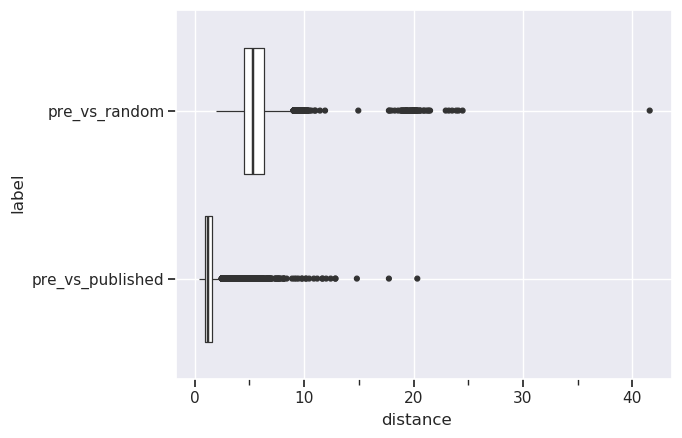

<ggplot: (-9223363262861330649)>


In [18]:
g = (
    p9.ggplot(final_df)
    + p9.aes(x="label",y="distance")
    + p9.geom_boxplot()
    + p9.coord_flip()
    + p9.theme_seaborn()
)
g.save("output/biorxiv_article_distance.svg", dpi=500)
g.save("output/biorxiv_article_distance.png", dpi=500)
print(g)

# Find bioRxiv unpublished ->  published PMC articles

In [19]:
biorxiv_unpublished = (
    biorxiv_journal_mapped_df
    .query("pmcid.isnull()")
)
biorxiv_unpublished.head()

,document,pmcid,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,...,feat_290,feat_291,feat_292,feat_293,feat_294,feat_295,feat_296,feat_297,feat_298,feat_299
1,000042_v2.xml,NaN,-0.697319,-0.342986,-0.248835,-0.111381,0.244663,-0.238119,-0.140737,0.221334,...,-0.126911,0.238912,-0.035375,-0.044733,-0.693987,-0.188221,0.615959,0.625472,-0.067295,-0.161871
3,000091_v1.xml,NaN,-0.460216,-0.077183,-0.346650,0.354429,0.540097,-0.367523,-0.597944,-0.026886,...,0.313261,-0.251339,0.563322,0.144810,-0.369955,-0.624727,0.338073,0.619281,-0.313213,-0.013729
5,000125_v1.xml,NaN,-0.349029,-0.058982,-0.719901,0.026207,0.141680,-0.115684,0.046131,0.166014,...,0.535506,0.340714,0.074378,-0.057494,-0.821460,-0.439156,0.277295,0.518959,-0.120806,-0.046501
8,000208_v1.xml,NaN,-0.441060,0.022983,-0.028331,0.140660,0.039678,0.135683,0.175794,-0.349661,...,0.096533,0.152653,-0.071144,0.096906,-0.832964,-0.323743,0.585995,0.801026,0.113852,0.144746
9,000216_v1.xml,NaN,-0.878772,-0.382037,0.242107,0.273857,-0.240972,-0.685833,-0.162845,0.632005,...,-0.514925,-0.151738,-0.114430,-0.211827,-0.670710,-0.032114,1.047945,0.428050,0.091200,-0.024027


In [20]:
PMC_unlinked = (
    pmc_journal_mapped_df
    .query(
        f"""
        document not in {
            biorxiv_published
            .reset_index()
            .pmcid
            .tolist()
        }
        """
    )
)
PMC_unlinked.head()

,journal,document,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,...,feat_290,feat_291,feat_292,feat_293,feat_294,feat_295,feat_296,feat_297,feat_298,feat_299
0,Environ_Health,PMC1552054,-0.428596,0.004477,-0.153677,0.059131,-0.394598,-0.066383,0.358798,-0.245809,...,-0.067994,0.033121,-0.077121,-0.433617,-1.111247,-0.405260,0.293903,0.613155,-0.500204,-0.214057
1,Environ_Health,PMC1226148,-0.434013,-0.185516,-0.070654,0.488759,-0.280275,0.042681,0.116685,0.037062,...,0.318905,-0.065244,0.159258,-0.380412,-0.665559,-0.485417,0.180982,0.523053,-0.485158,-0.251244
2,Environ_Health,PMC5635510,-0.248388,0.118660,-0.103008,0.267721,0.278939,-0.220584,0.089593,-0.159638,...,0.081127,-0.110091,-0.031617,-0.188741,-0.936947,-0.461118,0.618781,0.647195,-0.270240,-0.409643
3,Environ_Health,PMC3125232,-0.507224,0.024099,-0.039696,-0.171992,0.371326,-0.137797,-0.202616,-0.156994,...,-0.218274,-0.022597,-0.028885,-0.250560,-1.140730,-0.568136,0.482088,0.899122,-0.250971,-0.592976
4,Environ_Health,PMC3533997,-0.424435,0.175519,-0.048797,0.178023,-0.042913,-0.282377,0.317917,-0.007002,...,-0.111805,-0.262620,-0.187817,-0.463804,-1.308874,-0.352892,0.251982,0.550853,-0.659678,-0.614042


In [21]:
median_cutoff = (
    final_df
    .query("label=='pre_vs_published'")
    .median()
    .distance
)
median_cutoff

1.221926132654185

In [22]:
chunksize=1000
chunk_iterator = range(
    0, biorxiv_unpublished.shape[0], 
    chunksize
)

In [23]:
for idx, chunk in tqdm.tqdm(enumerate(chunk_iterator)):
    
    # Chunk the documents so memory doesn't break
    biorxiv_subset = (
        biorxiv_unpublished
        .iloc[chunk:chunk+chunksize]
    )
    
    # Calculate distances
    paper_distances = cdist(
        biorxiv_subset.drop(["document", "pmcid"], axis=1), 
        PMC_unlinked.drop(["journal", "document"], axis=1),
        'euclidean'
    )
    
    # Get elements less than threshold
    sig_indicies = np.where(paper_distances < 1.22)
    results = zip(
        sig_indicies[0],
        sig_indicies[1],
        paper_distances[paper_distances < 1.22]
    )
    
    # Map the results into records for pandas to parse
    results = list(
        map(
            lambda x: dict(
                document=biorxiv_subset.iloc[x[0]].document,
                pmcid=PMC_unlinked.iloc[x[1]].document,
                distance=x[2]
            ),
            results
        )
    )
    
    # There may be cases where there are no matches
    if len(results) > 0:
        # Generate pandas dataframe
        potential_matches_df = (
            biorxiv_journal_df[["document", "doi"]]
            .merge(
                pd.DataFrame
                .from_records(results)
            )
            .sort_values("distance")
        )
    
        # Write to file
        if idx == 0:
            potential_matches_df.to_csv(
                "output/potential_biorxiv_pmc_links.tsv", 
                sep="\t", index=False
            )

        else:
            potential_matches_df.to_csv(
                "output/potential_biorxiv_pmc_links.tsv", 
                sep="\t", index=False,
                mode="a", header=False
            )


54it [5:13:53, 348.77s/it]
